# ME599 - AI in Clean Energy Watt's Next
Team Members: Ricardo Lee, Evan Muschler, Vinh Nguyen, Noah Tanner

## 1. Installation of Requisite Libraries
Installs all the python packages listed in requirements.txt that are necessary to run the program. The main package of interest is aerosandbox.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
import neuralfoil as nf

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
from scipy.stats import qmc
from scipy.spatial import distance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs
import os
from scipy.stats.qmc import Sobol
from itertools import product
import seaborn as sns

from BEM import BEM_analysis

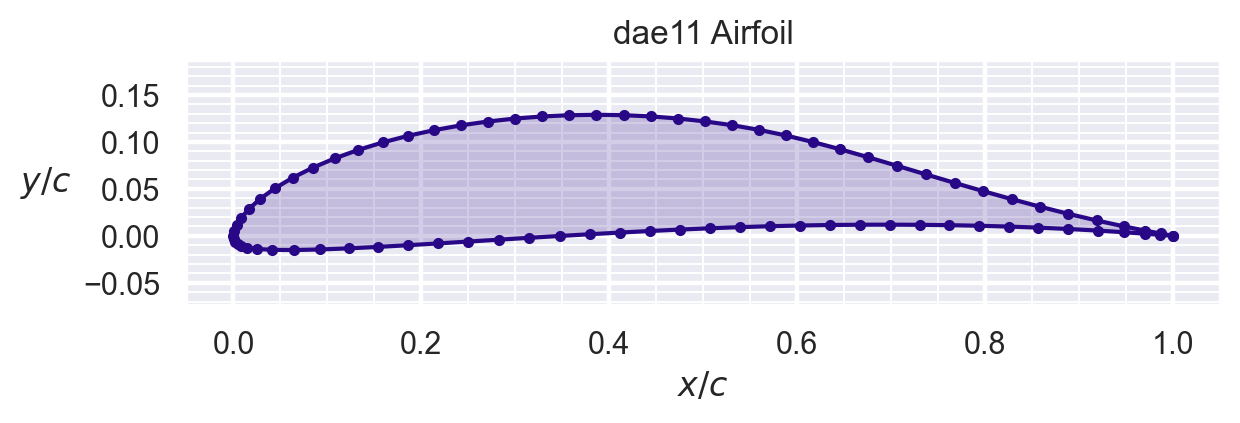

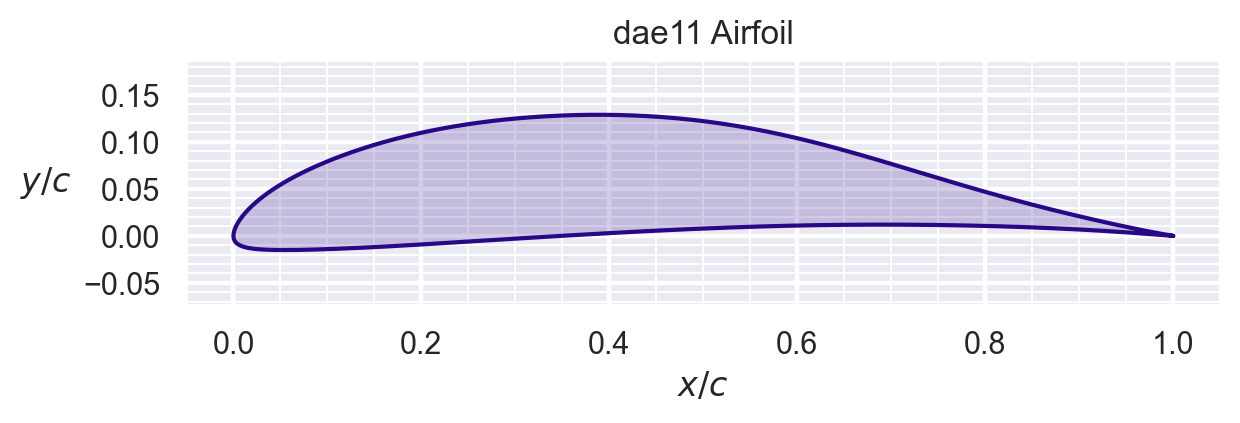

{'lower_weights': array([-0.16310508, -0.14398528,  0.08896135, -0.0706084 ,  0.09741634,
        0.01466031,  0.07888292,  0.08075122]), 'upper_weights': array([0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449,
       0.14345864, 0.28990386, 0.16207357]), 'leading_edge_weight': np.float64(0.5035068867316266), 'TE_thickness': np.float64(0.00011059192135127555)}


In [3]:
# Testing the packaged airfoil generation code. First makes a regular airfoil from airfoil database.
coordinate_airfoil = asb.Airfoil("dae11")
# coordinate_airfoil
fig, ax = plt.subplots(figsize=(6, 2))
coordinate_airfoil.draw()
# Converts airfoil to kulfan parameterized airfoil. It looks the same, but the dots aren't plotted so the figure looks smoother. 
kulfan_airfoil = coordinate_airfoil.to_kulfan_airfoil()
kulfan_airfoil
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()
# prints parameters so we can see how data is formatted
print(kulfan_airfoil.kulfan_parameters)

{'lower_weights': [-0.16310508, -0.14398528, 0.08896135, -0.0706084, 0.09741634, 0.01466031, 0.07888292, 0.08075122], 'upper_weights': [0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449, 0.14345864, 0.28990386, 0.16207357], 'leading_edge_weight': 0.5035068867316266, 'TE_thickness': 0.00011059192135127555}


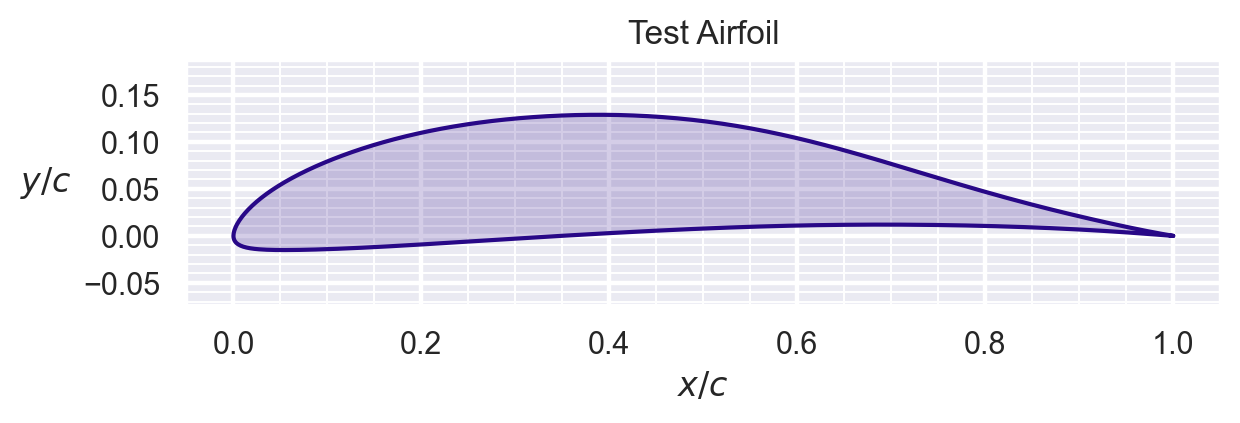

In [4]:
# test to just see how we can play around with airfoil shapes based on kulfan parameters
test = asb.KulfanAirfoil(
    name="Test",
    lower_weights=[-0.16310508, -0.14398528,  0.08896135, -0.0706084 ,  0.09741634,
        0.01466031,  0.07888292,  0.08075122],
    upper_weights=[0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449,
       0.14345864, 0.28990386, 0.16207357],
    leading_edge_weight=0.5035068867316266,
    TE_thickness=0.00011059192135127555,
)
print(test.kulfan_parameters)
fig, ax = plt.subplots(figsize=(6, 2))
test.draw()

## 3. Define Neural Foil Helper Functions
Here, we define helper functions that help us put the Kulfan Parameters into a Bayesian Optimization-friendly state. The Kulfan parameters are by default in a dictionary, but we want them in a single list format for easy data manipulation. 

Also makes helper functions that can make the next foils to try based on the new parameters chosen by Bayesian Optimization.

In [5]:
# This converts the dictionary of Kulfan parameters into a single list. 
def kulfan_to_bo(kf_params):
    list_lower = kf_params["lower_weights"]
    list_upper = kf_params["upper_weights"]
    leading_edge = kf_params["leading_edge_weight"]
    trailing_edge = kf_params["TE_thickness"]
    result = [leading_edge, trailing_edge, *list_upper, *list_lower]
    return result

# This converts the list of Bayesian Optimization parameters back into a Kulfan parameter dictionary for the AeroSanbox library
def bo_to_kulfan(bo):
    result = {"leading_edge_weight": bo[0],
              "TE_thickness": bo[1],
              "upper_weights": bo[2:9],
              "lower_weights": bo[10:17]}
    return result

# Helper function to generate airfoils from given Kulfan parameters. Mostly there to help automate the code during BO process
def make_foil_kf(kf, name):
    foil = asb.KulfanAirfoil(
    name=name,
    lower_weights=kf["lower_weights"],
    upper_weights=kf["upper_weights"],
    leading_edge_weight=kf["leading_edge_weight"],
    TE_thickness=kf["TE_thickness"],
)
    return foil

import aerosandbox as asb
import numpy as np
import pandas as pd

def create_performance_from_kulfan(
    kf: dict,
    name: str = "custom_airfoil",
    alpha_range: tuple = (-10, 20, 1),  # (start, stop, step)
    reynolds_list: list = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6],
    output_file: str = "neuralfoil_custom_airfoil.xlsx"
):
    # Create Kulfan airfoil
    foil = asb.KulfanAirfoil(
        name=name,
        lower_weights=kf["lower_weights"],
        upper_weights=kf["upper_weights"],
        leading_edge_weight=kf["leading_edge_weight"],
        TE_thickness=kf["TE_thickness"],
    )

    # Define AoA range
    alphas = np.arange(*alpha_range)

    # Collect results
    data = []
    for Re in reynolds_list:
        for alpha in alphas:
            result = foil.get_aero_from_neuralfoil(alpha=alpha, Re=Re)
            data.append({
                "Re": Re,
                "alpha": alpha,
                "CL": result["CL"][0],
                "CD": result["CD"][0],
            })

    # Convert to DataFrame and save
    df = pd.DataFrame(data)
    df.to_excel(output_file, index=False)
    return df

## 4. Define BEM Functions to Calculate Cp
Define the BEM functions that are used to calculate Cp from AeroSandbox - NeuralFoil's calculations of drag (Cd) and lift (Cl) at different angles of attack.

{'lower_weights': [-0.16310508, -0.14398528, 0.08896135, -0.0706084, 0.09741634, 0.01466031, 0.07888292, 0.08075122], 'upper_weights': [0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449, 0.14345864, 0.28990386, 0.16207357], 'leading_edge_weight': 0.5035068867316266, 'TE_thickness': 0.00011059192135127555}
cl: [1.23106968], cd: [0.00734731]
foil: {'Re': array([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 2000000.,
       2000000., 2000000., 2000000., 2000000., 2000000., 2000000.,
       2000000., 2000000., 2000000., 2000000., 2000000., 2000000.,
       2000000., 2000000., 2000000., 2000000., 2000000., 2000000.,
       2000000., 2000000., 2000000., 2000000., 2000000., 2000000.,
       2000000., 2000000., 200000

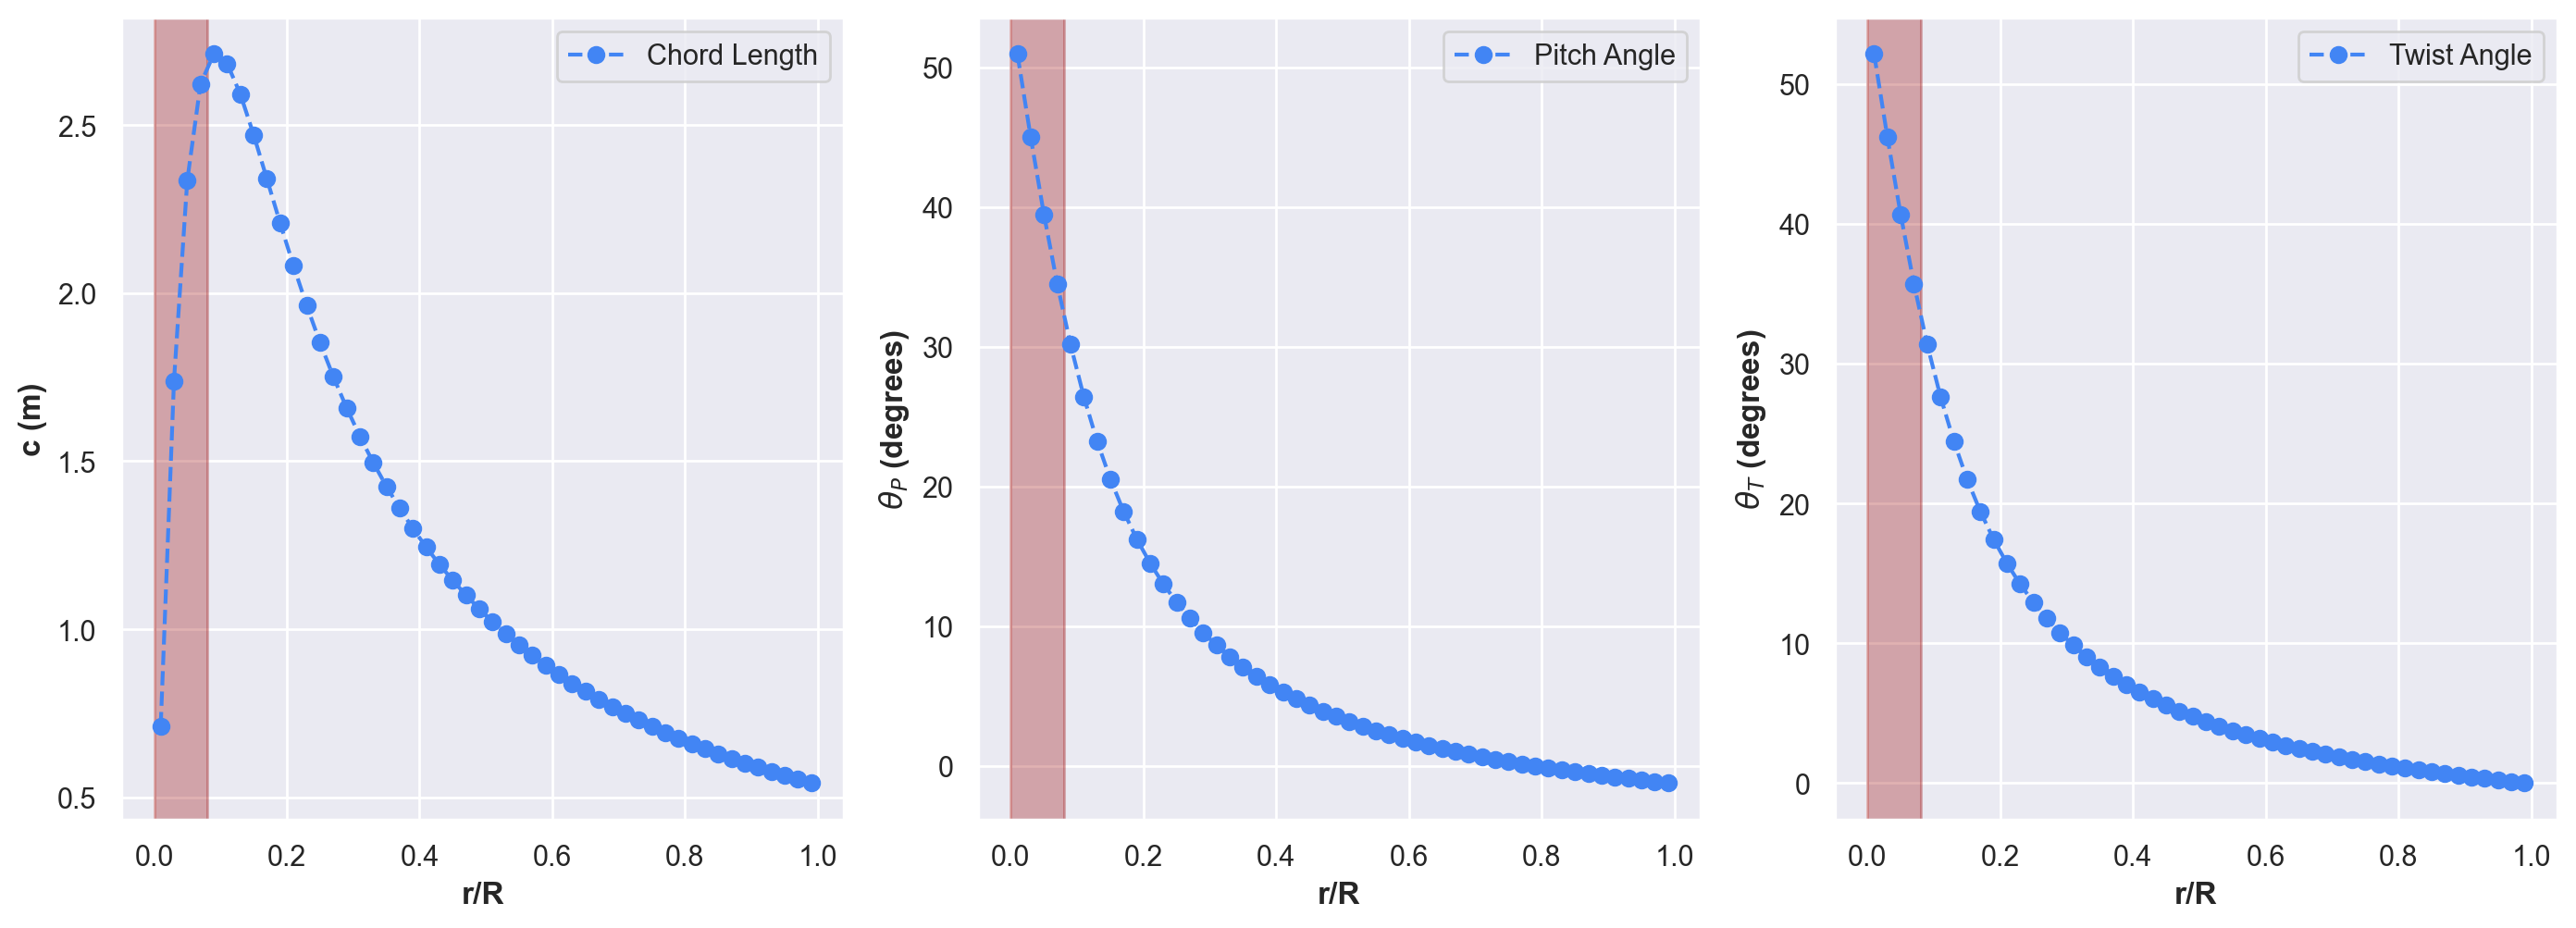

/Users/tanno/Documents/GitHub/WattsNext/helperfunctions_template.py:96: RuntimeWarning: overflow encountered in exp
  F = (2/np.pi)*np.acos(np.exp(-(B/2)*(R-r)/(r*np.sin(phi))))
/Users/tanno/Documents/GitHub/WattsNext/helperfunctions_template.py:96: RuntimeWarning: invalid value encountered in arccos
  F = (2/np.pi)*np.acos(np.exp(-(B/2)*(R-r)/(r*np.sin(phi))))


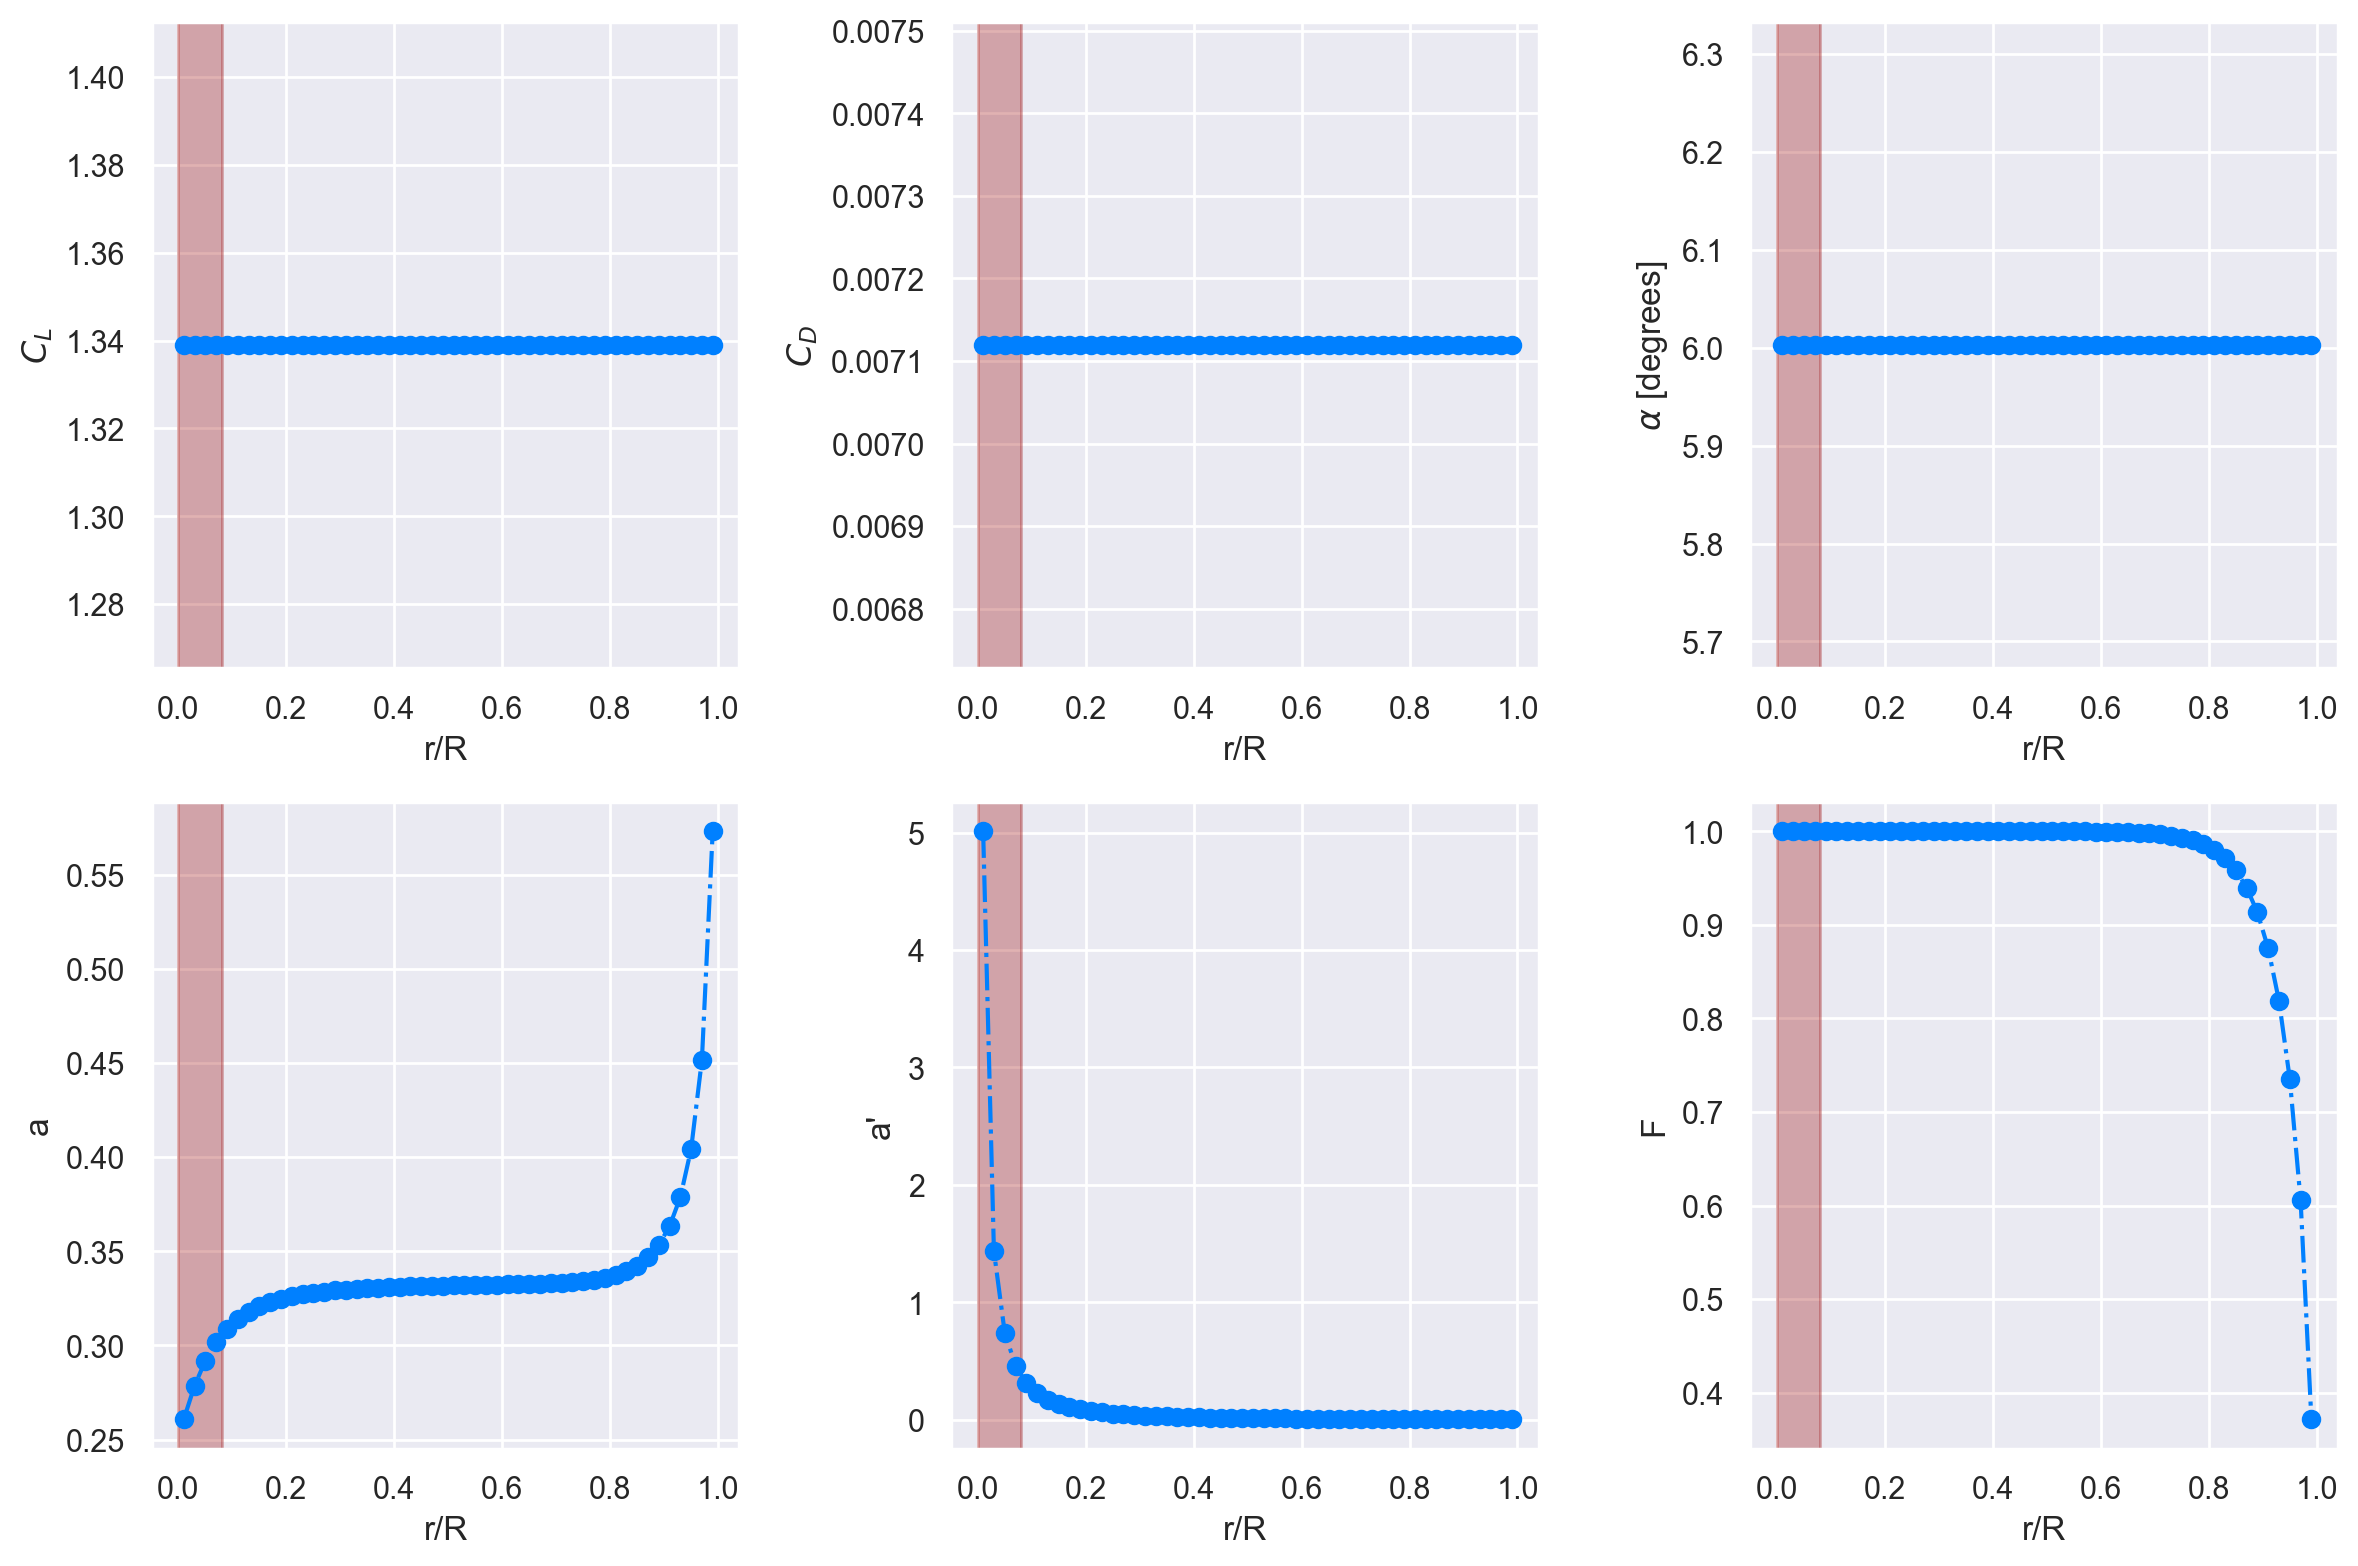

CP: 0.5367650969240497
CT: 1.6581971285613646


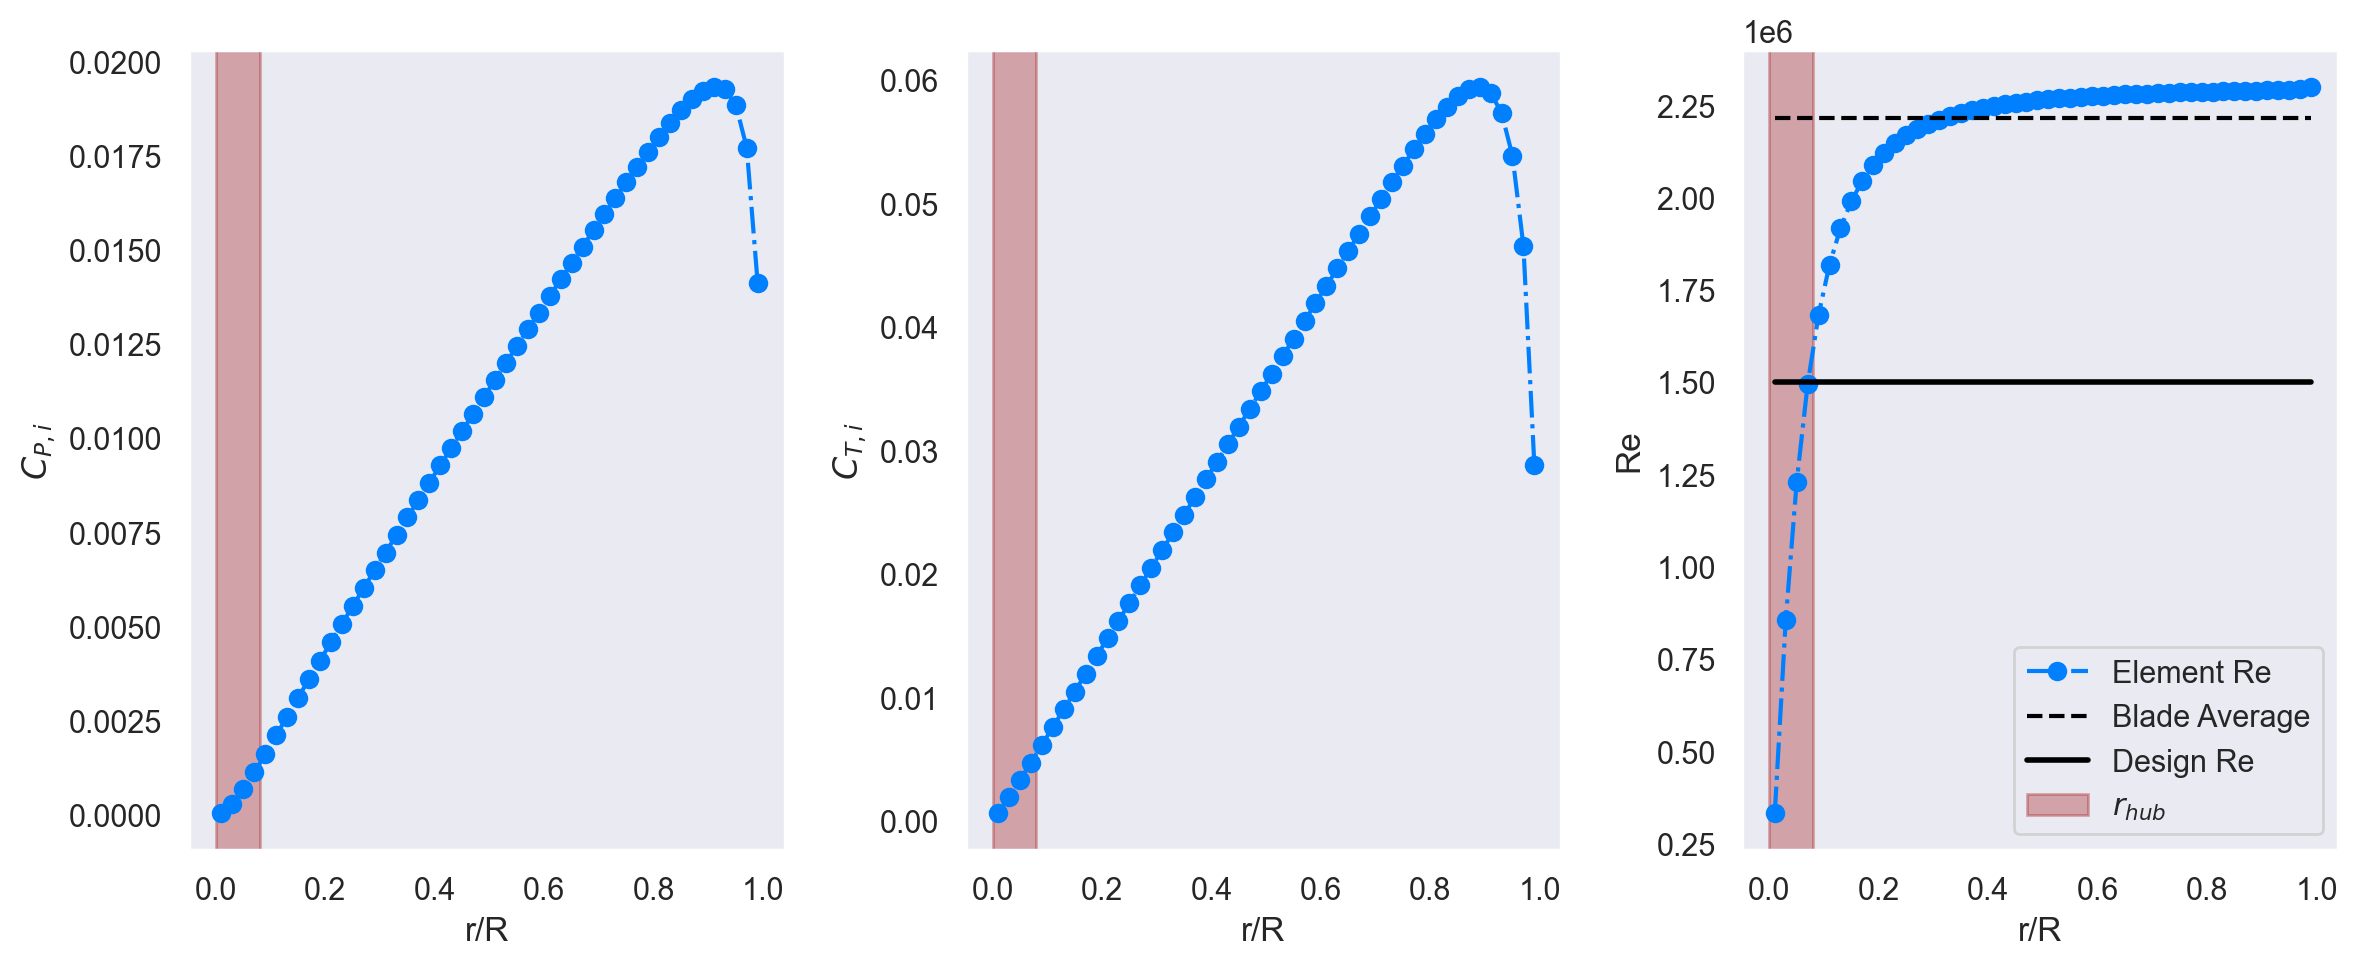

In [6]:
# function gets cl, cd from kulfan parameters and then the unchanging input values
def cl_cd_from_kulfan(kf, name: str, alpha: float, re: float, mach: float) -> dict:
    print(kf.kulfan_parameters)
    af = make_foil_kf(kf.kulfan_parameters, name)
    aero = nf.get_aero_from_airfoil(
        airfoil = af,
        alpha = alpha,
        Re = re
    )

    return aero["CL"], aero["CD"]

# test to see it works
cl, cd = cl_cd_from_kulfan(test, "test", 5.0, 1e6, 0.5)
print(f"cl: {cl}, cd: {cd}")

# Initial parameters for optimization, needed to run BEM

# Turbine properties
U_design = 8  # Design wind speed [m/s]
R = 25  # Turbine radius [m]
eta_0 = 0.90  # Balance of system efficiency
lambda_design = 8  # Design tip speed ratio
B = 3  # Number of blades
r_hub = 2  # Hub radius [m]

# BEM discretization
N = 50  # Number of elements per blade

# Air properties
rho = 1.2  # Wind density - kg/m3
nu = 1.511e-5  # Kinematic viscosity of air at 20 C [m^2/s]

performance_file = create_performance_from_kulfan(test.kulfan_parameters, "test", (-10, 20, 1), [1e6, 2e6, 3e6, 4e6, 5e6, 6e6], "neuralfoil_custom_airfoil.xlsx")

performance_file_path = "neuralfoil_custom_airfoil.xlsx"

# Air properties
rho = 1.2  # Wind density - kg/m3
nu = 1.511e-5  # Kinematic viscosity of air at 20 C [m^2/s]

Re_design = 1.5e6  # Start with blade design Re (1.5e6), then update to actual 
# Set up solver for function minimization
# Note: these options specify a maximum iterations and tolerance for convergence
options = {'maxiter': 1e5, 'tol': 1e-7}

# Plot style
BEM_color = np.array([0, 128, 255]) / 255

CP, CT, Re = BEM_analysis(U_design, R, eta_0, lambda_design, B, r_hub, N, performance_file_path, Re_design, options, BEM_color, rho, nu)

## 5. Define a Bayesian Optimization Model
Defines a Bayesian Optimization Model to optimize Cp given the 18 Kulfan parameters

### 5.1 Define conditions for optimization
What are the conditions that we are trying to optimize our airfoil for? Here, we set wind velocity, Reynolds number ($Re$), Mach number ($M_{inf}$), the hub radius of the wind turbine ($r_{hub}$), the number of blades ($n$), the total turbine radius ($r_t$), and a range for the angle of attack ($\alpha$).

In [7]:
# Initial parameters for optimization 

re = 106
m_inf = 0.2
r_hub = 50 #m
n = 3 
r_t = 100 #m
alpha = [5, 15]

### 5.2 Define Objective Function

### 5.3 Bayesian Optimization Setup

NOTE: This is Austin's code from class one time. Just a starting point for setup.

In [8]:
# Optimization Parameters
hyperparameter = 0.01
threshold = 0.025
scaling_factor = 50

# Gaussian Process Regression model
kernel = C(constant_value=1, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=False)

# Expected Improvement maximizes implicetly
def expected_improvement(X, X_sample, y_sample, model):
    mu, sigma = model.predict(X, return_std=True)

    optiminal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):

        imp = mu - optiminal_sample - hyperparameter
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

# Function to propose the next sample point using Expected Improvement
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    dim = X_sample.shape[1]

    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp)

    # Starting points for optimization
    x0_list = np.random.uniform(0, 1, size=(n_restarts, dim))
    best_x, best_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x
    return best_x

### 5.4 

## 6. Data Visualization
Function to visualize how the airfoil changes shape as it goes through the Bayesian Optimization process

In [9]:
# will plot the number of foils based on a list of Nx2 arrays
def plot_optimization(list_array, num_foils):
    color_palette = sns.color_palette("crest", num_foils + 1)
    fig, ax = plt.subplots(figsize=(6, 2))
    count_array = len(list_array)
    step_size = int(np.floor(count_array/(num_foils - 1)))
    j = 0
    ax.plot(list_array[0][:,0], list_array[0][:,1], color = color_palette[j])
    # ax.plot(list_array[0][:,0], list_array[0][:,1])
    for i in range(1, count_array - 1, step_size):
        j += 1
        ax.plot(list_array[i][:,0], list_array[i][:,1], color = color_palette[j])
        # ax.plot(list_array[i][:,0], list_array[i][:,1])
    ax.plot(list_array[-1][:,0], list_array[-1][:,1], color = color_palette[j+1])
    # ax.plot(list_array[-1][:,0], list_array[-1][:,1])

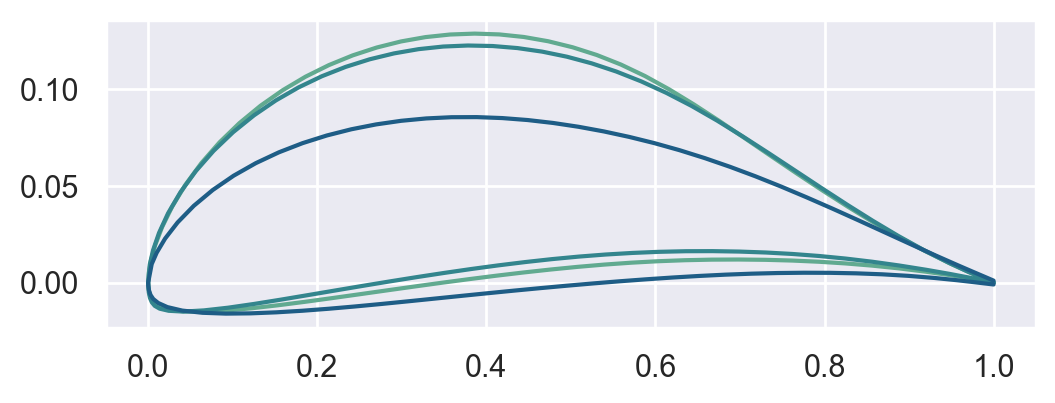

In [10]:
test1 = asb.Airfoil("dae11")
test2 = asb.Airfoil("dae21")
test3 = asb.Airfoil("dae31")
test4 = asb.Airfoil("dae51")
list_array = [test1.coordinates, test2.coordinates, test3.coordinates, test4.coordinates]

plot_optimization(list_array, 2)

In [11]:
bo_test = kulfan_to_bo(test.kulfan_parameters)

print(bo_test)

[0.5035068867316266, 0.00011059192135127555, 0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449, 0.14345864, 0.28990386, 0.16207357, -0.16310508, -0.14398528, 0.08896135, -0.0706084, 0.09741634, 0.01466031, 0.07888292, 0.08075122]


In [12]:
kf_test = bo_to_kulfan(bo_test)
print(kf_test)

{'leading_edge_weight': 0.5035068867316266, 'TE_thickness': 0.00011059192135127555, 'upper_weights': [0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449, 0.14345864, 0.28990386], 'lower_weights': [-0.16310508, -0.14398528, 0.08896135, -0.0706084, 0.09741634, 0.01466031, 0.07888292]}


In [13]:
test2 = make_foil_kf(kf_test, "Test2")

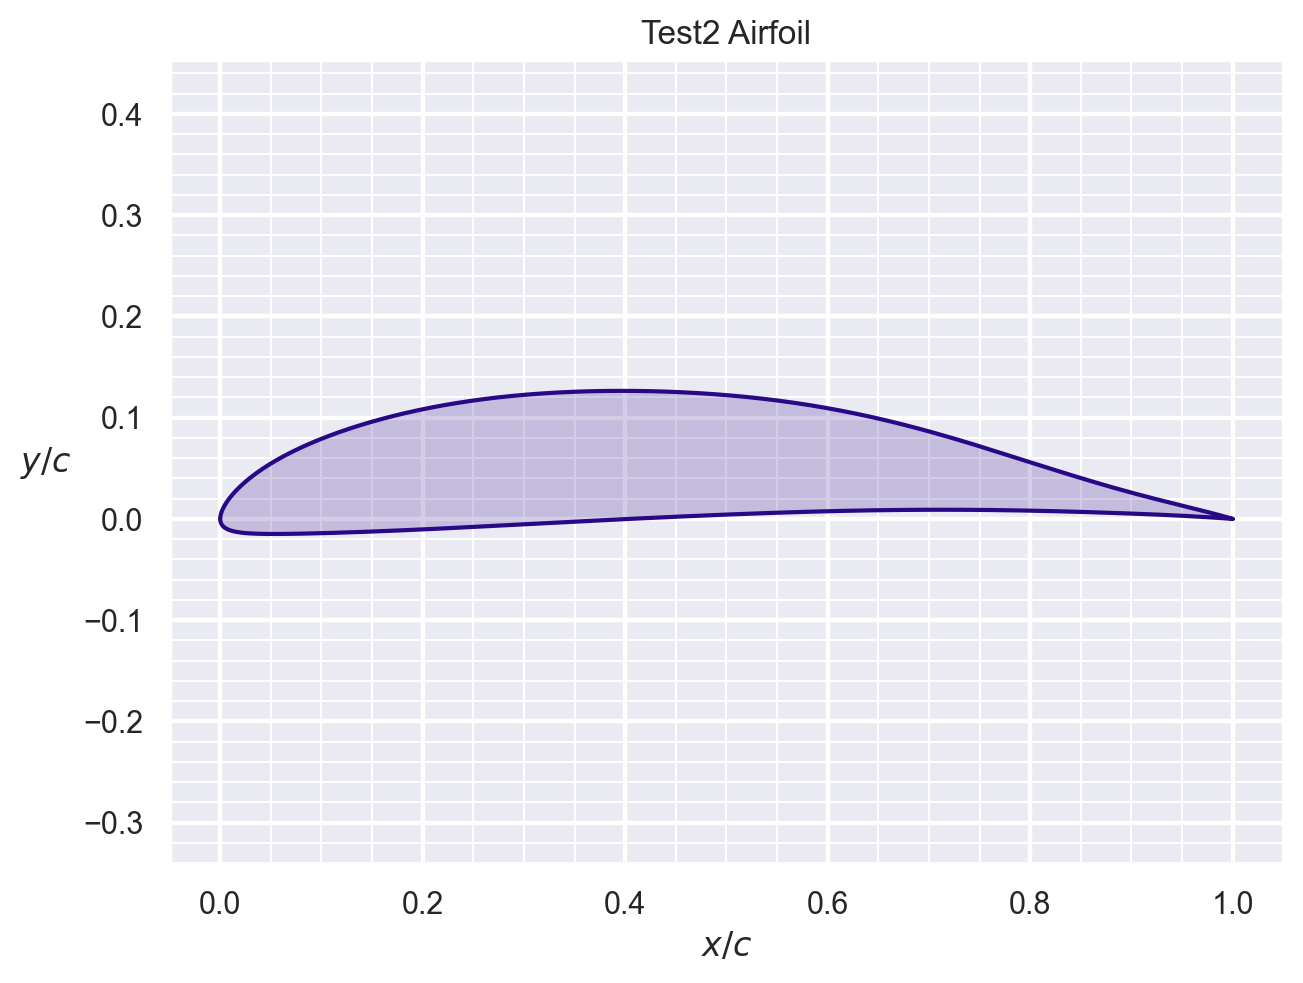

In [14]:
test2.draw()

In [15]:
coords = test2.coordinates
test3 = asb.Airfoil("test3", coords)

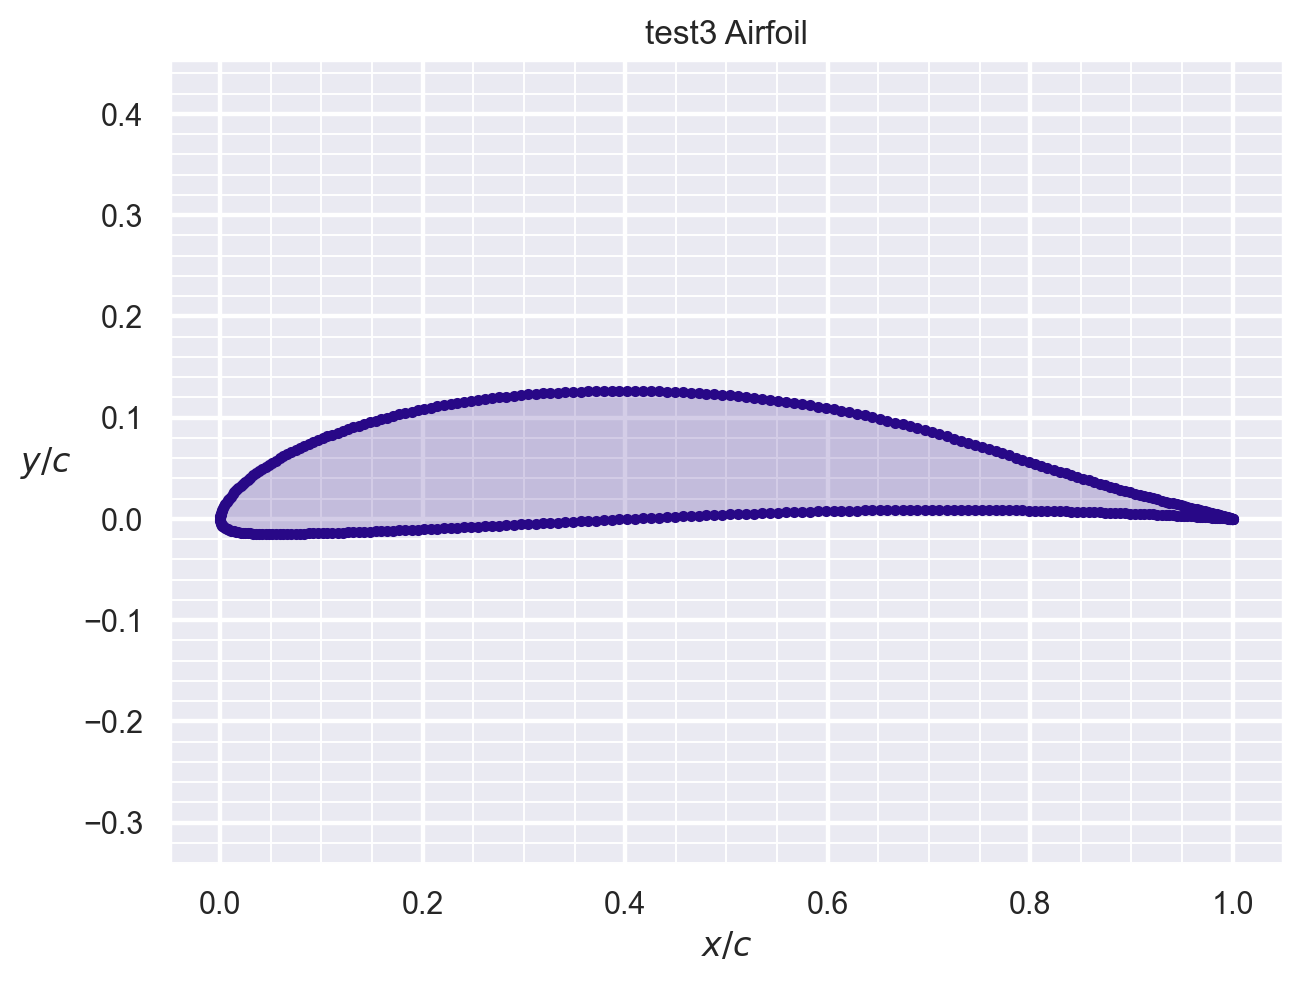

In [16]:
test3.draw()